DimensionPatch

In [2]:
import os   # for path operations
import datetime

import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12415088213286158814
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11569674254437989565
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# nb_input_series : time + 9 IMU data + optional prev. beta (min 10)
# nb_outputs : beta () or quvaternion representation) (min 1)

def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
  model = Sequential()
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(nb_outputs,activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

In [5]:
def make_timeseries_instances(timeseries,window_size):
  timeseries = np.asarray(timeseries)
  assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
  X = np.atleast_3d(np.array([timeseries[start:start+window_size] for start in range(0,timeseries.shape[0]-window_size)]))
  y = timeseries[window_size:]
  return X,y

In [6]:
def evalute_timeseries(X, Y, window_size, filter_length, nb_filter, valid_split, test_split, patience, epochs, batch_size):
  early_stopping=EarlyStopping(patience=patience, verbose=1)
  checkpointer=ModelCheckpoint(filepath="weights_bazs.hdf5", save_best_only=True, verbose =1)

  nb_samples = X.shape[0]
  nb_series = X.shape[2]
  
  # Model definition (previously definied) 10 input chanel, 1 output chanel
  model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series,
                        nb_outputs=1,nb_filter=nb_filter)
  model.summary()
    
  valid_size = int(nb_samples*(1-test_split-valid_split))
  test_size = int(nb_samples*(1-test_split))
  X_train, Y_train = X[:valid_size], Y[:valid_size]
  X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
  X_test, Y_test   = X[test_size:], Y[test_size:]
    
  model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, Y_valid), verbose=2, callbacks = [checkpointer,early_stopping])
    
  preds=model.predict(X_test)
  targets = Y_test

  plt.plot(preds)
  plt.plot(targets)
  return preds, targets

# Load Data

In [7]:
lock_meas = '..\\..\\DATA\\RAW\\Measure_02' # Location folder of the measurement files
file_list = os.listdir(lock_meas)           # Make a list out of the files in the folder
nb_meas = len(file_list)/4                  # Every measurement contains 4 file (IMU, MoCap, Robotino, NFO)

meas_list = []                              # Make a list containing the independent measurements
for FILE_NAME in file_list:
    meas_list.append(FILE_NAME[0:22])       # The unique ID is the time, the first 22 character
meas_list = list(set(meas_list))

# Load in one favourite measurement block
meas_id = 4

# Syncronise the measurement files from MoCap and IMU
if meas_id>(nb_meas-1):
    meas = 0
meas_date = str(meas_list[meas_id])

# Load the IMU csv data file
imu_data = pd.read_csv(lock_meas + '\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

# Load the MoCap csv data file
mocap_data = pd.read_csv(lock_meas + '\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])

# Merge the two data file to synronise them. In both dataset there are some data row that can't be matched, this data will
# be trown away
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')

# ===== Filters ======

# When the magneto sensors values are [0, 0, 0] that is a false value. These rows are deleted.
# When tacked is 0, it is indicates that the MoCap data is invalid. These rows are deleted too.
df = data[~(data[['mag0','mag1','mag2','tracked']] == 0).any(axis=1)]
# From now on the tracked column can be deleted, because it contains only 1s.
del df['tracked']
# Add to more columns to make a fluent orientation function (orient) and a delta time (deltat)
df = df.assign(orient=0)
df = df.assign(deltat=0)
df = df.assign(level=0)
# Convert the data frame into numpy array
dfarray = np.array(df)
# Create a lookup table to make the use of this matrix more readable.
time   = 0
acc0   = 1
acc1   = 2
acc2   = 3
gyro0  = 4
gyro1  = 5
gyro2  = 6
mag0   = 7
mag1   = 8
mag2   = 9
x      = 10
y      = 11
z      = 12
beta   = 13
Qx     = 14
Qy     = 15
Qz     = 16
Qw     = 17
orient = 18
deltat = 19
level  = 20

# Calculate the delta time between two valid measurements
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        dfarray[i,deltat] = dfarray[i,time]-dfarray[i-1,time]

# Creating a more fluent orientation function
level = 0
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        if (dfarray[i,beta]-dfarray[i-1,beta])>355:
            level = level - 1
        if (dfarray[i,beta]-dfarray[i-1,beta])<-355:
            level = level + 1
        else:
            level = level   
        dfarray[i, orient] = level*360 + dfarray[i, beta]

In [8]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 100
patience=50
batch_size = 16
vs = 0.15
ts = 0.15

In [17]:
dfarray.shape

(1659, 21)

In [31]:
Y = dfarray[window_size:,orient]
X = dfarray[:,0:9]

In [32]:
X.shape

(1659, 9)

In [33]:
Y.shape

(1639,)

In [34]:
X = np.atleast_3d(np.array([X[start:start+window_size] for start in range(0,X.shape[0]-window_size)]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             184       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________
Train on 114


Epoch 00038: val_loss did not improve from 125352.93216
Epoch 39/100
 - 0s - loss: 24940.5530 - mean_absolute_error: 127.8515 - val_loss: 126458.3186 - val_mean_absolute_error: 342.2092

Epoch 00039: val_loss did not improve from 125352.93216
Epoch 40/100
 - 0s - loss: 24938.2302 - mean_absolute_error: 127.8447 - val_loss: 126488.0608 - val_mean_absolute_error: 342.2527

Epoch 00040: val_loss did not improve from 125352.93216
Epoch 41/100
 - 0s - loss: 24935.8790 - mean_absolute_error: 127.8384 - val_loss: 126517.8952 - val_mean_absolute_error: 342.2963

Epoch 00041: val_loss did not improve from 125352.93216
Epoch 42/100
 - 0s - loss: 24933.5303 - mean_absolute_error: 127.8319 - val_loss: 126546.9959 - val_mean_absolute_error: 342.3388

Epoch 00042: val_loss did not improve from 125352.93216
Epoch 43/100
 - 0s - loss: 24931.1531 - mean_absolute_error: 127.8257 - val_loss: 126573.8673 - val_mean_absolute_error: 342.3780

Epoch 00043: val_loss did not improve from 125352.93216
Epoch 44

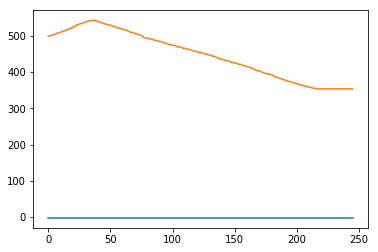

In [35]:
pred, target = evalute_timeseries(X, Y, window_size,filter_length,nb_filter, vs, ts, patience, epochs, batch_size)

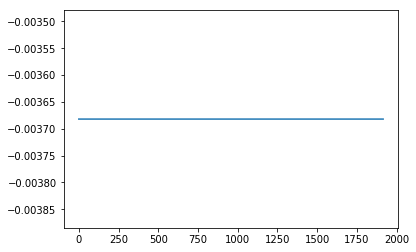

In [31]:
plt.plot(pred)